In [1]:
import os
import pandas as pd
import librosa
from tqdm import tqdm
import numpy as np
import random
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import os
import librosa
from multiprocessing import Pool
import time
import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
BASE_DIR = '/kaggle/input/ben10/ben10'
train_data_dir = f"{BASE_DIR}/16_kHz_train_audio/"
test_data_dir = f"{BASE_DIR}/16_kHz_valid_audio/"
data_path = f"{BASE_DIR}/train.csv"

In [3]:
split2path = {
    "train": train_data_dir,
    "test": test_data_dir,
}

In [4]:
data = pd.read_csv(data_path)

In [5]:
def extract_split(filename):
    filename_ = filename.split("_")
    split = filename_[0]
    return split

def extract_district(filename):
    filename_ = filename.split(" ")[0]
    district = filename_.split("_")[1]
    return district

def beautify_dataset(data):
    splits = []
    districts = []
    newpaths = []
    transcripts = []
    
    for i in range(len(data)):
        filename, transcript = data.iloc[i]
        split = extract_split(filename)
        district = extract_district(filename)
        dir_path = split2path[split]
        composed_path = f"{dir_path}{filename}"
        
        if os.path.exists(composed_path) == False:
            print(f"{composed_path} does not exist.")
            continue
        
        # replace any newline characters
        transcript = transcript.replace("\n", " ")
        transcript = " ".join(transcript.split())
        
        splits.append(split)
        districts.append(district)
        newpaths.append(composed_path)
        transcripts.append(transcript)
    
    data['file_path'] = newpaths
    data['district'] = districts
    data['split'] = splits
    data['transcripts'] = transcripts
    
#     data.drop(columns=['file_name'], inplace=True)
    
    return data

In [6]:
data = beautify_dataset(data)

In [7]:
df = pd.read_csv("/kaggle/input/ben10/ben10/train.csv")
test = pd.read_csv("/kaggle/input/ben10/sample_submission.csv")

df.head()

,file_name,transcripts
0,train_sandwip (1).wav,আইচ্ছা। আমনেরা এনজিও সম্পর্কে কিছু জানেন নে? জ...
1,train_sandwip (2).wav,তো এগুনেত্তে কিল্লাই টিঁয়া লন? টিঁইয়া লই আঙ্গো...
2,train_sandwip (3).wav,কিয়া কোইত্তো? মানে টিয়াঁ লইতে অইলে ফতম দিন না...
3,train_sandwip (4).wav,"তো টিয়া চালাইলে এ সপ্তাহ ন ঐ সপ্তাহ দিবো ক, এড..."
4,train_sandwip (5).wav,"সদইস্য থাকে, এগুন বেগ্গুনরে ডাকা লাওয়া। ডাকি আ..."


In [8]:
print("Total samples in Train set :",df.shape[0])
print("Total samples in test set",len(os.listdir("/kaggle/input/ben10/ben10/16_kHz_valid_audio")))

Total samples in Train set : 13610
Total samples in test set 1703


In [9]:
def extract_regions(path):
    unwanted_strs = ["train_","valid_",".wav","1","2","3","4","5","6","7","8","9","0","(",")"," "]
    for i in unwanted_strs:
        path = path.replace(i,"")
    
    return path
df["region"] = df["file_name"].apply(lambda x:extract_regions(x))
test["region"] = test["id"].apply(lambda x:extract_regions(x))
list(df["region"].unique())

['sandwip',
 'barishal',
 'chittagong',
 'habiganj',
 'kishoreganj',
 'narail',
 'narsingdi',
 'rangpur',
 'sylhet',
 'tangail']

# EDA on transcript

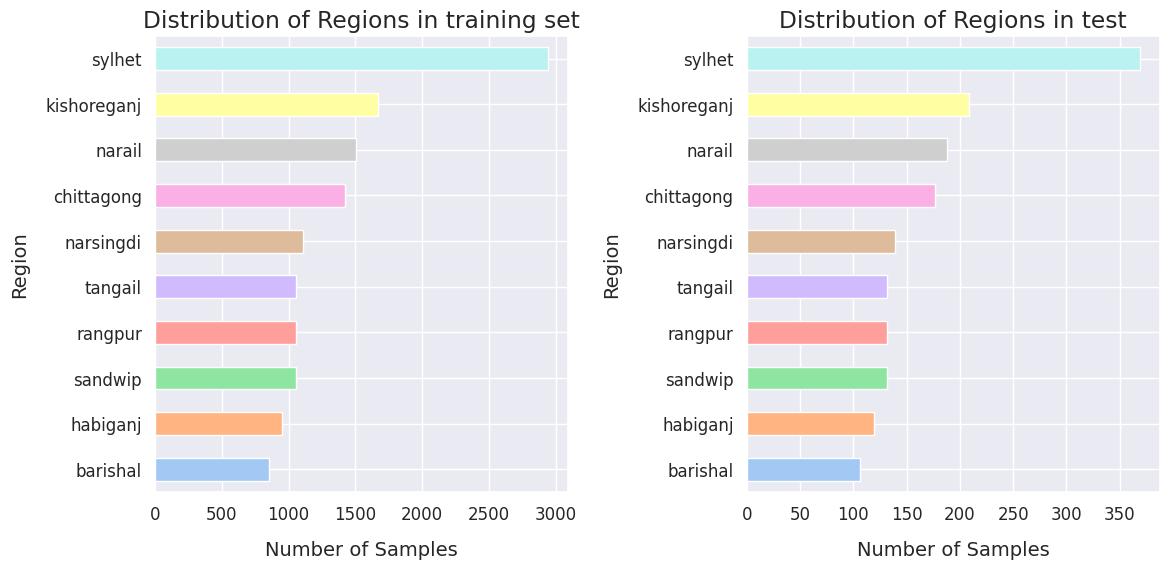

In [10]:
custom_palette = sns.color_palette("pastel")

# Set the background style
sns.set_style("whitegrid")

# Set font scale
sns.set(font_scale=1.4)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of regions in the training set
df['region'].value_counts().sort_values().plot(kind='barh', ax=axes[0], color=custom_palette)
axes[0].set_title('Distribution of Regions in training set')

# Plot the distribution of regions in the test set
test['region'].value_counts().sort_values().plot(kind='barh', ax=axes[1], color=custom_palette)
axes[1].set_title('Distribution of Regions in test')

# Add labels and title with increased font size
for ax in axes:
    ax.set_xlabel("Number of Samples", labelpad=12, fontsize=14)
    ax.set_ylabel("Region", labelpad=12, fontsize=14)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
train_dir = "/kaggle/input/ben10/ben10/16_kHz_train_audio/"
paths = [train_dir+path for path in os.listdir(train_dir)]
#print("First two path : ",paths[:2])

def get_duration(file):
    try:
        # Load audio file
        y, sr = librosa.load(file, sr=None)
        # Calculate duration
        duration = librosa.get_duration(y=y, sr=sr)
        return duration
    except Exception as e:
        return file, None

def get_durations_parallel(files):
    with Pool() as pool:
        results = pool.map(get_duration, files)
    return results


#Getting durations here. ALso checking how much time does it take to laod all the audios
start = time.time()
durations_train = get_durations_parallel(paths)
test_dir = "/kaggle/input/ben10/ben10/16_kHz_valid_audio/"
test_paths = [test_dir+path for path in os.listdir(test_dir)]
durations_test = get_durations_parallel(test_paths)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


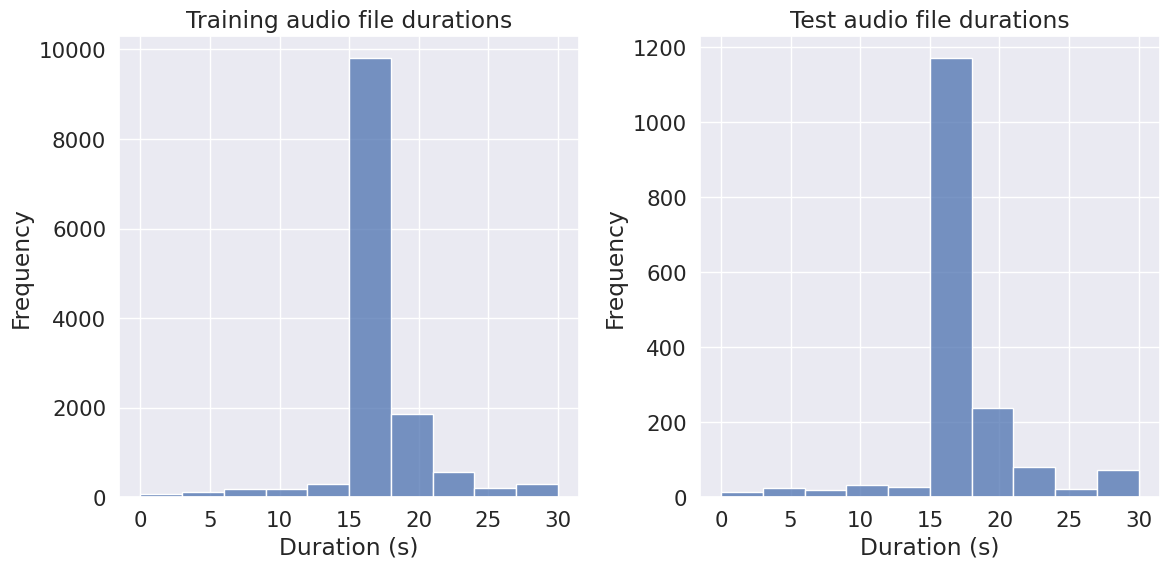

In [12]:
sns.set_style("whitegrid")

# Set font scale
sns.set(font_scale=1.4)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the training data histogram
sns.histplot(durations_train, bins=[i for i in range(0, 31, 3)], ax=axes[0])
axes[0].set_title('Training audio file durations')
axes[0].set_xlabel('Duration (s)')
axes[0].set_ylabel('Frequency')

# Plotting the test data histogram
sns.histplot(durations_test, bins=[i for i in range(0, 31, 3)], ax=axes[1])
axes[1].set_title('Test audio file durations')
axes[1].set_xlabel('Duration (s)')
axes[1].set_ylabel('Frequency')

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


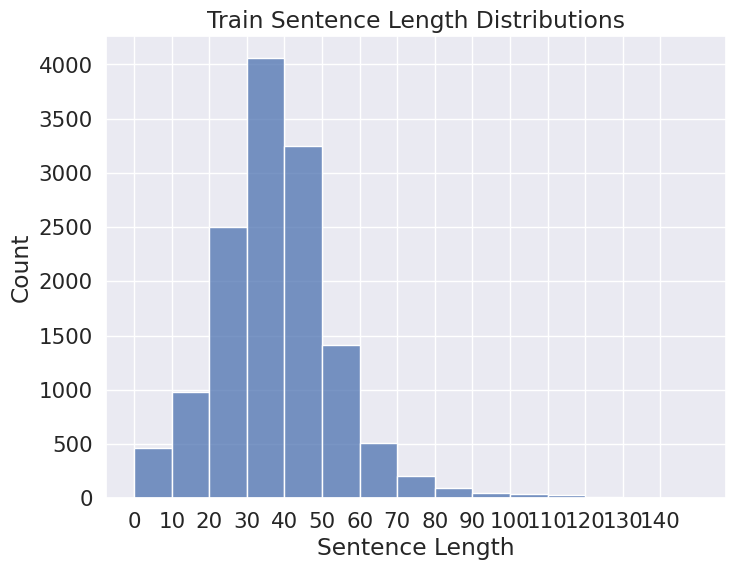

In [13]:
sns.set_style("whitegrid")

sns.set(font_scale=1.4)


df['len'] = df['transcripts'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.histplot(df['len'], bins=[i for i in range(0, 151, 10)], kde=False)
plt.xticks(np.arange(0, 150, step=10))
plt.xlabel('Sentence Length')
plt.title('Train Sentence Length Distributions')

# Show the plot
plt.show()

In [14]:
df[df['len']==0]

,file_name,transcripts,region,len
3590,train_habiganj (267).wav,...,habiganj,0
13505,train_tangail (953).wav,,tangail,0


In [15]:
df[df['len']<10]

,file_name,transcripts,region,len
129,train_sandwip (130).wav,"আইচ্ছা, আইচ্ছা যাই হোক ঠিকাছে, কতা কই ভালা লাই...",sandwip,9
235,train_sandwip (236).wav,অ্যাক্কান ঘর দিতে হারে ন। হু।,sandwip,6
637,train_sandwip (638).wav,ভাবি ধরেন্না আন্নে আঁই <>,sandwip,5
721,train_sandwip (722).wav,<>,sandwip,1
761,train_sandwip (762).wav,<> সন্দ্বীপের মানুষ অই <> আইচ্চা <>,sandwip,7
...,...,...,...,...
13505,train_tangail (953).wav,,tangail,0
13512,train_tangail (960).wav,নিজের মেয়া বলে সব হারাইছে। <> \n,tangail,6
13586,train_tangail (1034).wav,হুম। ভোদাই। বোকা। হ্যালো? ছালুন। কী কী? ছালুন।,tangail,8
13592,train_tangail (1040).wav,জি ভাই অয়েট। আপনি বলেন হইলো। ভাবসাব। কী? শ্বাশ...,tangail,9


In [16]:
df[df['len']>100]

,file_name,transcripts,region,len
535,train_sandwip (536).wav,আমনে ব্যাবহার <> আরে জোতা এগিন আন্নেরে কে কইবো...,sandwip,110
551,train_sandwip (552).wav,ইয়ান <> রেক্সিন লাগাছে এমনে অ্যা তো হিয়া নিজে ...,sandwip,113
555,train_sandwip (556).wav,"ভাড়াদেন ভাড়াদেন আইয়েন। ভাড়া আইজ্জা দিতান্ন, ভা...",sandwip,115
593,train_sandwip (594).wav,"তোরে এক কতা বুঝাই দি, অ্যা, ইয়া <> সাথে তোরে ক...",sandwip,121
594,train_sandwip (595).wav,"<> হিয়ারে জিজ্ঞাচ্চা এগিন আই হিয়ারে কইছি, আই ক...",sandwip,110
...,...,...,...,...
13421,train_tangail (869).wav,"সম্পদ, ট্যাহা আছাল দেইখা খুব ভগ-ভগ <> ও তো ত্য...",tangail,110
13423,train_tangail (871).wav,"বিশ লাক, বিশ লাক ট্যাকা চাইলে, বিশ লাক ট্যাহা ...",tangail,114
13427,train_tangail (875).wav,"আছাল। আরে ওইডা খাল, জলাশয়। এইদিক দিয়া পানি পাস...",tangail,125
13428,train_tangail (876).wav,ওইডা মোটামুটি বন্দ কইরা হালাইছে। ওইযে বিপ্লব আ...,tangail,127


- there are some very short and very large transcripts that need to be handled

In [17]:
vocab = {}
for sen in df.transcripts:
    for j in sen.split(" "):
        try:
            vocab[j]+=1
        except:
            vocab[j]=1
print("Total words in vocabulary : ",len(vocab))

sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:10]

Total words in vocabulary :  84557


[('<>', 10608),
 ('', 8205),
 ('তো', 7587),
 ('না', 5089),
 ('আর', 4912),
 ('যে', 4840),
 ('আমি', 4226),
 ('না।', 4076),
 ('কি', 3464),
 ('আমার', 3318)]

In [18]:

def plot_world(text):

    wordcloud = WordCloud(width = 500, height = 500, 
                    background_color ='black', 
                    font_path="/kaggle/input/notosansfont/NotoSansBengali_Condensed-Regular.ttf",
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (5, 5), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

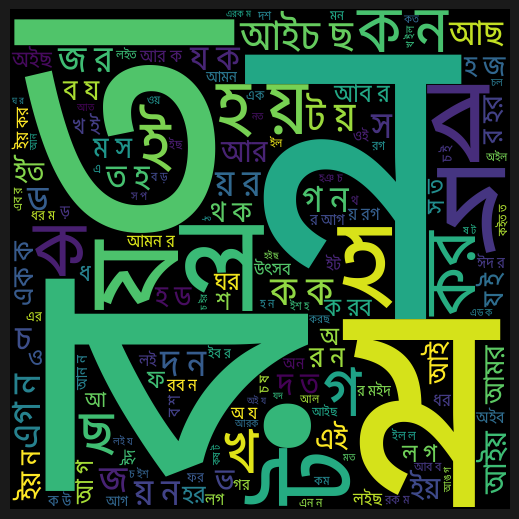

In [19]:
s= " ".join(df.transcripts[:100])
plot_world(s)

In [20]:
chars = {}
for sen in df.transcripts:
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars

{'আ': 52828,
 'ই': 103583,
 'চ': 16750,
 '্': 72560,
 'ছ': 39994,
 'া': 289671,
 '।': 54340,
 ' ': 500709,
 'ম': 73426,
 'ন': 110660,
 'ে': 161249,
 'র': 141979,
 'এ': 29637,
 'জ': 21959,
 'ি': 120886,
 'ও': 24273,
 'স': 40298,
 'প': 16622,
 'ক': 85784,
 'ু': 50526,
 '?': 18405,
 'ত': 78554,
 'ো': 56921,
 ',': 29575,
 'ট': 33657,
 'ল': 70232,
 'হ': 32339,
 'য়': 48502,
 'উ': 8236,
 'গ': 34063,
 'দ': 45144,
 'ব': 66051,
 'ড়': 9155,
 'খ': 32679,
 'ড': 15331,
 'ঁ': 6195,
 'ঙ': 1237,
 'অ': 16480,
 'ফ': 20662,
 'শ': 14803,
 'ঞ': 1528,
 'ৈ': 517,
 'য': 37013,
 'ঐ': 109,
 'ঘ': 2174,
 '-': 5656,
 'ষ': 5849,
 'থ': 6714,
 'ং': 3106,
 '<': 11761,
 '>': 11751,
 'ঝ': 2119,
 'ধ': 4125,
 '\u200c': 146,
 'ভ': 9380,
 '\n': 13361,
 'ূ': 699,
 "'": 168,
 '৷': 628,
 'ঠ': 2170,
 'ী': 4972,
 'ৌ': 638,
 'ণ': 1426,
 'ঋ': 55,
 'ৎ': 339,
 'ঈ': 220,
 '!': 1842,
 '়': 890,
 'ঢ': 652,
 '\u200d': 69,
 'ৃ': 539,
 '"': 172,
 '\xa0': 342,
 'ঃ': 58,
 '/': 6,
 '.': 401,
 'ঊ': 44,
 '*': 2,
 'ঔ': 23,
 'ঢ়': 8,
 '(': 4,
 'I'

- english characters and numbers need to be removed

# EDA on Audio

In [21]:
import random

def display_random_audio(region):
    sample = df[df["region"] == region]
    idx = random.randint(0, len(sample) - 1)

    file = sample['file_name'].iloc[idx]
    path = train_dir + file
    
    print("Region:", region)
    display(AudioSegment.from_file(path))
    print("Transcript:", sample['transcripts'].iloc[idx])


In [22]:
regions = ['sandwip', 'barishal', 'chittagong', 'habiganj', 'kishoreganj', 
           'narail', 'narsingdi', 'rangpur', 'sylhet', 'tangail']

for region in regions:
    display_random_audio(region)
    print("\n")


Region: sandwip


Transcript: ডিম দি দিবি, বুইজ্জচ্ছে? তই এই এক কাপ ঠাট্রা হানি দি আগে ডিম উজ্ঞা দি গুলিয়ালাবি, গুলিয়েলাইলে এগিন এগিন মানে শক্ত শক্ত মিক্যা মানি কায় অইবো, রুটির ক্ষেত্রে আরো নরম অইবোরি, এক্কানা বেরাইন্না কায় অইবো।


Region: barishal


Transcript: এ আফু কিছু কইয়া যান, মুই অইছি এই মিম আফুর ফুবাতো বুইন বোজ্জেন? মুই অই কাবাবে এট্টু সাহায্য করছেলাম, আর এই অইলো, মোর ছোডো মাইয়া, মোগো বুইনের মাইয়া মাশা-আল্লা! মাশা-আল্লা! সবাই মাশা-আল্লা কইয়া দিয়েন, সবাই মাশা-আল্লা কইয়েন। এই নামডা কইয়া দাও সোনামণি। বলো আমার নাম সারা, সারা মনি



Region: chittagong


Transcript: আর বিভিন্ন সুতাটুতা কিন্যুম, সুতাটুতা কিনিয়ারে এই খতিকগিন উলের সুতা আছে ইয়্যিন দিয়েরেও বিভিন্ন ফুলটুল বানাইয়্যুম। বানাইয়েরে অইলদে জগত মইদ্দ্যে এইল্লা সাজাই রাখি দিয়্যুম, রাখিয়ারে সুন্দর গরি সাজাই রাইখ্যুম।


Region: habiganj


Transcript: এরূ বাইত তো দুইলা বেশাইয়াই দেওন লাগে। <> দেওয়াইন্নার মারে, মাসুদা বেডি বাইতওই না। খই? গেছে সানখলা, বেডির জামাই আজকু যাগা ওমরা হজো। 



Region: kishoreganj


Transcript: গঞ্জ। ফরে কয়, "যাও, যাও, এইডাই তুমাদের লাস্ট পরিক্ষা না?" <> "জি স্যার।" "একবারে বাড়িতে চলে যাও। পরিক্ষায়, ক্লাস টাস আর হবে না। দেরি আছে অনেক। বাড়িতে চলে যাও" স্যারের কথা শুইন্যা আমার অনেক মজা লাগছে। আর আমরা সবাই অনেক খুশি অইছি যে ক্লাস টাস আর হবে না। আমরা, আমরা সবাই অনেক কনফিউজড আছিলাম যে ক্লস হইবো কি অইতো না, অইবো কি অইতো না। পরে দেহি যে। আমরার পরিক্ষার সময় জানছ কি অইছে? মানে আমার সামনে বুইচ্ছস দিনার। আর দিনাররে তো তুই জানছই মানে কত ফ্রেন্ড সার্কেল লইয়া চলে। 


Region: narail


Transcript: সাথে সাথে আমার নামে কেস অবে। কেস অবে এটেম্পট টু মাডার।
ওরে বাবারে বাবা! মানে তুমি দেখতিছে সুকুমারের ছায়াল এট্টু ফড়াল্যাহা শিহিছে। চাকরি-বাকরি কইরে এট্টা কিছু বড় কিছু ওইয়ে যায়। তালি তো গাইড় মারা। 
বড় কিছু হওয়া লাগবে না ভাই। নিজির চলার মতো এট্টা চাকরি কত্তি পাল্লিও মনে কর তাগে গায় জ্বালা।


Region: narsingdi


Transcript: তহন, হায়রে! আর আমি মেহেদি শিখছি যে সান্জি আপুর লগে জিদ কইরা। ইলার কছে একবার সকালে যাইয়া বইয়া রইছি। সকালেতেও ফার্স্টে  দুফুর পর্যন্ত। তহন তো ছুডু আছিলাম। রোজা রাখতাম না। ফরে আবার দুফুরে খাইয়া-টাইয়া আবার যাইয়া বইয়া আছিলাম। এহে। তহনো ফরে, ফরে। <> কালকা রাত্রে মেন্দি ফরাইয়া দিবো। এই চুপ থাক। <> । ফরেও <> ।


Region: rangpur


Transcript: কিছু করিনে। না পড়ি এই যে এহনা ব্যবসা বাণিজ্য করবের নাগছি। টাকটুক করি চইলবের নাগছি। সে ব্যবসাও খুব অবস্তা খারাপ। এই কারণে মানুষ এহনা চিন্তে ভাবনা করবের নাগছি মনে করো জমি নেমো।


Region: sylhet


Transcript: আজকে একটা প্ল্যান বানাইছি যে আমরা সব কাজিন হখল মিলিয়া অলা মাতাত থাখমু। তে ওউ ছাইর জন, বেশির‍ভাগ সময় ওউ ছাইর জন, আমরা ওলা মাতাত থাখমু আর <> ওউ মাতার মাজখানো আমরার এখটা ছবি তুলবা <> পোস্ট ছারিয়া <> ক্যানডিড। ইগু মনো খয় তাইর আইডিয়া আইছে তাইর দেখলাম এখটা ফ্রেন্ডে


Region: tangail


Transcript: কিন্তু এহন খারাপ তো সব। হিন্দুই কি আর মুসলমানই কি সবই খারাপ। সবই। মনে করো কেউ জানলো খারাপ আর কেউ না জানলে খারাপ। হ। তবে আমার মতে কি মনে অয় কি জানো? পেম করার জন্য মুসলমান মে বেটার। হিন্দু মেয়ে এহন কুনু কুনু পুটকিমারা দেয় কিবা আমি কহামনা। না আমার কাছে যা মনো অয়। মুসলমানগো হাতে পেম করো গা কোনো সমস্যা নাই। তাই? সমস্যা থাকলেও কোনো ঝামেলা নাই। ঝামেলা নাই? আমার যা যা মনো অয়।




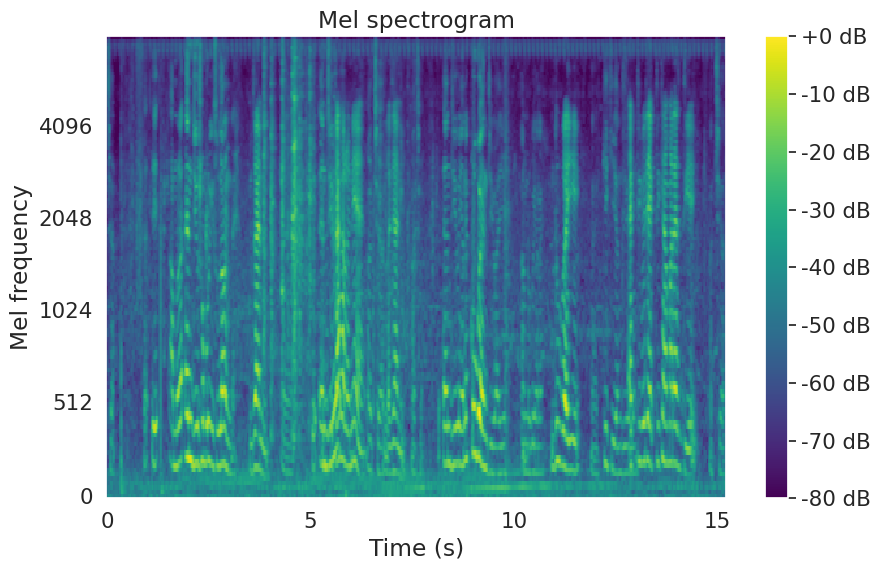

In [23]:
file_path = data['file_path'].iloc[0]

# Load the audio file
y, sr = librosa.load(file_path, sr=None)

# Compute the mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel',cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel frequency')
plt.show()

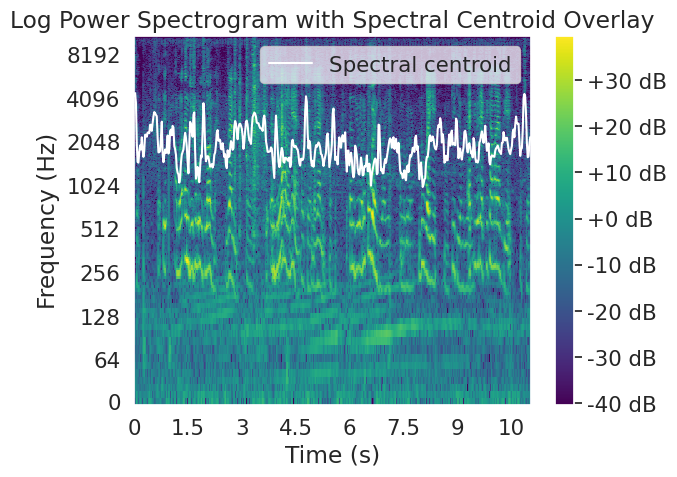

In [24]:
file_path = data['file_path'].iloc[0]

# Load the audio file
y, sr = librosa.load(file_path, sr=None)

# Compute the log power spectrogram
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(S))

# Compute the spectral centroid
cent = librosa.feature.spectral_centroid(y=y, sr=sr)

# Plot the log power spectrogram with the spectral centroid overlay
times = librosa.times_like(cent)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax, cmap='viridis')

# Plot the spectral centroid
ax.plot(times, cent.T, label='Spectral centroid', color='w')

# Add colorbar and legend
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.legend(loc='upper right')

# Set title and labels
ax.set(title='Log Power Spectrogram with Spectral Centroid Overlay')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.show()